0.009212684584781528


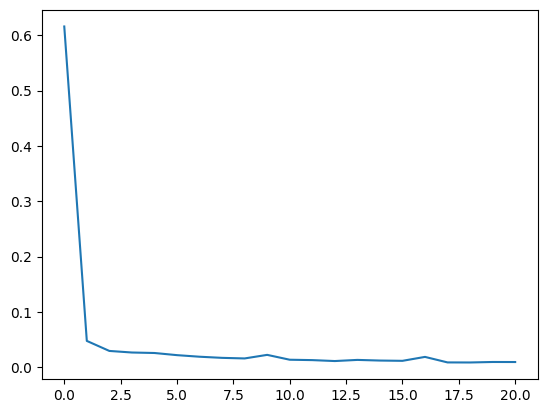

In [158]:
import matplotlib.pyplot as plt
import pickle
import torch
import numpy as np
from staf import INR, StafLayer
from PIL import Image

with open('./headshot_gaussian_10_losses.pkl', 'rb') as file:
        losses = pickle.load(file)
print(losses[-1])
plt.plot(losses)
plt.show()

In [156]:
class ImageINRModel(torch.nn.Module):

    def __init__(self):
        super(ImageINRModel, self).__init__()

        self.input = torch.nn.Linear(1024, 256)
        self.l1 = torch.nn.Linear(256, 256)
        self.l2 = torch.nn.Linear(256, 256)
        self.l3 = torch.nn.Linear(256, 256)
        self.l4 = torch.nn.Linear(256, 256)
        self.output = torch.nn.Linear(256, 3)

        self.activation = torch.nn.ReLU()
        self.sig = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.input(x)
        x = self.activation(x)
        x = self.l1(x)
        x = self.activation(x)
        x = self.l2(x)
        x = self.activation(x)
        x = self.l3(x)
        x = self.activation(x)
        x = self.l4(x)
        x = self.activation(x)
        x = self.output(x)
        x = self.sig(x)

        return x

In [137]:
def fourier_encode(xy: torch.Tensor, freq: torch.Tensor) -> torch.Tensor:

    # Expand: (N, 2) → (N, 1, 2)
    xy = xy.unsqueeze(1)  # shape: (N, 1, 2)

    # (F,) → (1, F, 1), for broadcasting

    freq1 = freq[0:len(freq)//2 ]
    freq2 = freq[len(freq)//2:]

    
    freq1 = torch.tensor(freq1, dtype = torch.float32).view(1, -1, 1)
    freq2 = torch.tensor(freq2, dtype = torch.float32).view(1, -1, 1)

    # Multiply and encode
    scaled1 = 2 * torch.pi * (1/freq1) * xy  # shape: (N, F, 2)
    scaled2 = 2 * torch.pi * (1/freq2) * xy  # shape: (N, F, 2)

    sin_feat = torch.sin(scaled1)  # (N, F, 2)
    cos_feat = torch.cos(scaled2)  # (N, F, 2)

    # Concatenate and flatten last two dimensions: (N, F, 4) → (N, 4 * F)
    features = torch.cat([sin_feat, cos_feat], dim=-1)  # (N, F, 4)
    return features.view(xy.shape[0], -1)  # (N, 4 * F)

/tmp/ipykernel_133/2805376147.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(coords, dtype=torch.float32)  # (H*W, 2)


267


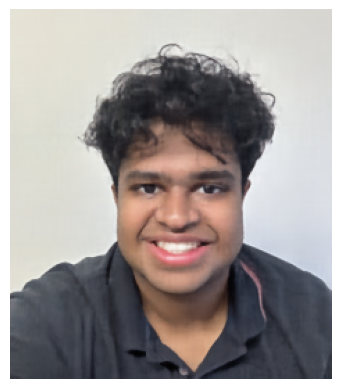

The image resolution is: 2316x2674


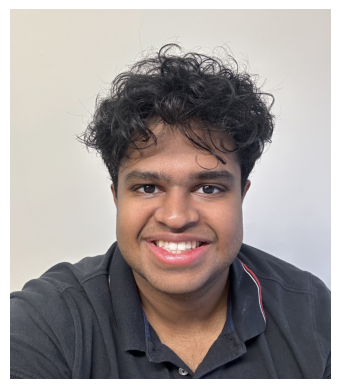

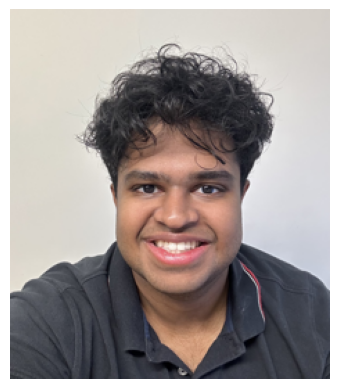

In [165]:
model = ImageINRModel()
#model = INR(2, 256, 4, 3)
path = './checkpoint.pth'

checkpoint = torch.load("headshot_gaussian_10.pth")
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

res_factors = [1]
for f in res_factors:
    H, W = 267*f, 232*f

    # Create normalized grid: x in [0, 1], y in [0, 1]
    x = np.linspace(0, 1, W)
    y = np.linspace(0, 1, H)
    xx, yy = np.meshgrid(x, y)  # shape: (H, W)

    coords = torch.tensor(np.stack([xx, yy], axis=-1).reshape(-1, 2), dtype = torch.float32)  # shape: (H*W, 2)
    with open('./freq_10.pkl', 'rb') as file:
        freq = pickle.load(file)

    coords = fourier_encode(coords, freq = freq)
    X = torch.tensor(coords, dtype=torch.float32)  # (H*W, 2)

    with torch.no_grad():
        Y = model(X)  # shape: (H*W, 3)

    image = Y.reshape(H, W, 3).cpu().numpy()
    image2 = (image * 255).astype(np.uint8)
    image2 = Image.fromarray(image2)
    image2.save('headshot_gaussian_10.png')

    print(H)

    # Clip values to [0, 1] if needed
    #image = np.clip(image, 0, 1)
    import matplotlib.pyplot as plt

    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
image = Image.open("./headshot.jpg").convert("RGB")

width, height = image.size

image2 = image.resize((width//10, height//10))

# Print the dimensions
print(f"The image resolution is: {width}x{height}")
plt.imshow(image)
plt.axis('off')
plt.show()
plt.imshow(image2)
plt.axis('off')
plt.show()

/tmp/ipykernel_133/342051168.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(coords, dtype=torch.float32)  # (H*W, 2)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.019552834..1.0158464].


267


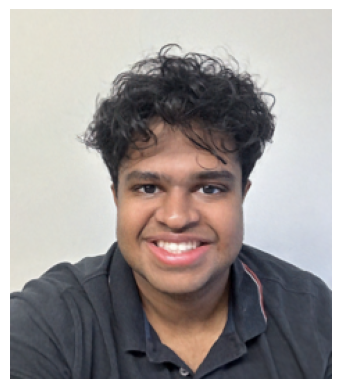

The image resolution is: 2316x2674


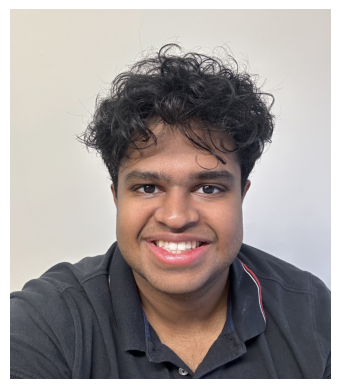

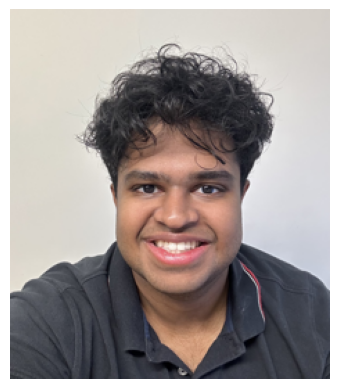

In [167]:
#model = ImageINRModel()
model = INR(2, 256, 4, 3)
path = './checkpoint.pth'

checkpoint = torch.load("headshot_STAF.pth")
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

res_factors = [1]
for f in res_factors:
    H, W = 267*f, 232*f

    # Create normalized grid: x in [0, 1], y in [0, 1]
    x = np.linspace(0, 1, W)
    y = np.linspace(0, 1, H)
    xx, yy = np.meshgrid(x, y)  # shape: (H, W)

    coords = torch.tensor(np.stack([xx, yy], axis=-1).reshape(-1, 2), dtype = torch.float32)  # shape: (H*W, 2)
    '''with open('./freq_10.pkl', 'rb') as file:
        freq = pickle.load(file)

    coords = fourier_encode(coords, freq = freq)'''
    X = torch.tensor(coords, dtype=torch.float32)  # (H*W, 2)

    with torch.no_grad():
        Y = model(X)  # shape: (H*W, 3)

    image = Y.reshape(H, W, 3).cpu().numpy()
    image2 = (image * 255).astype(np.uint8)
    image2 = Image.fromarray(image2)
    image2.save('headshot_STAF.jpg')

    print(H)

    # Clip values to [0, 1] if needed
    #image = np.clip(image, 0, 1)
    import matplotlib.pyplot as plt

    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
image = Image.open("./headshot.jpg").convert("RGB")

width, height = image.size

image2 = image.resize((width//10, height//10))

# Print the dimensions
print(f"The image resolution is: {width}x{height}")
plt.imshow(image)
plt.axis('off')
plt.show()
plt.imshow(image2)
plt.axis('off')
plt.show()